# Agentic RAG, Fine-Tuning Concepts & Evaluation

## Table of Contents
1. [AI Agents: The Core Concept](#1-ai-agents-the-core-concept)
2. [LLM Tools Fundamentals](#2-llm-tools-fundamentals)
   - [CUA](#computer-use-agents-cua)
3. [OpenAI and Anthropic Implementation](#3-openai-vs-anthropic-implementation)
4. [Model Context Protocol (MCP)](#4-model-context-protocol-mcp)
5. [Fine-Tuning Concepts](#5-fine-tuning)
6. [Evaluation & Benchmarking](#6-evaluation--benchmarking)

---


# 1. AI Agents: The Core Concept

## The Agent Formula

> **Agent = LLM + Tools + Ability to choose which tool to call and when**

An agent is more than just an LLM, it's an **autonomous system** that can:
- Observe its environment
- Make decisions
- Take actions
- Learn from feedback

## The ReAct Framework

ReAct (Reasoning + Acting) is the **dominant pattern for building agents**:

```text
┌──────────┐    ┌──────────┐    ┌─────────────┐    ┌──────────┐
│ THOUGHT  │ → │  ACTION  │ → │ OBSERVATION │ → │ THOUGHT  │ → ... → Final Answer
│ (Reason) │    │(Tool Call)│    │(Tool Result)│    │ (Reason) │
└──────────┘    └──────────┘    └─────────────┘    └──────────┘
```

**Example ReAct trace:**
```text
User: "What's the weather like in Paris and should I bring an umbrella?"

Thought: I need to find the current weather in Paris to answer this question.
Action: get_weather(location="Paris")
Observation: {"temperature": 15, "condition": "rainy", "humidity": 85%}

Thought: It's rainy in Paris with high humidity. I should recommend an umbrella.
Final Answer: "It's currently 15°C and rainy in Paris with 85% humidity. 
              Yes, you should definitely bring an umbrella!"
```



## RAG as an AI Agent Tool

Your Advanced RAG pipeline becomes a tool the agent can call:

```python
# RAG tool definition
{
    "name": "get_context_from_files_advanced",
    "description": "Search through uploaded documents to find relevant information. "
                   "Use when user asks questions about specific documents or needs "
                   "factual information from the knowledge base.",
    "parameters": {
        "type": "object",
        "properties": {
            "query": {"type": "string", "description": "The search query"},
            "top_k": {"type": "integer", "description": "Number of results to return"}
        },
        "required": ["query"]
    }
}
```

**When does the agent call RAG?**
- User asks about document content
- Question requires factual lookup
- Query contains references to "the document," "my files," etc.



## AI Agent VS Agentic RAG

AI AGENT = General Manager                                  
"Which department should handle this task?"                 
 → Sales? Engineering? Research? Finance?                    
                                                        
 AGENTIC RAG = Expert Researcher                             
 "How should I find this information?"                       
 → Which database? What search strategy? Need to refine? 


**Scope of Decisions:**   
```text
AI AGENT decides:                    AGENTIC RAG decides:
├── Should I search documents?       ├── How to interpret the query?
├── Should I search the web?         ├── Which retrieval method?
├── Should I run code?               ├── Which data sources?
├── Should I calculate?              ├── Are results good enough?
├── Should I ask for clarification?  ├── Should I re-retrieve?
└── How to combine tool results?     └── How much context to return?
```

They Can Work Together:       
```text
┌─────────────────────────────────────────────────────────┐
│                      AI AGENT                           │
│                (General decisions)                      │
│                        │                                │
│       ┌────────────────┼────────────────┐               │
│       ▼                ▼                ▼               │
│ ┌──────────┐    ┌──────────┐    ┌──────────┐            │
│ │ AGENTIC  │    │   Web    │    │  Code    │            │
│ │   RAG    │    │  Search  │    │ Executor │            │
│ │(Retrieval│    │          │    │          │            │
│ │decisions)│    │          │    │          │            │
│ └──────────┘    └──────────┘    └──────────┘            │
│                                                         │
│ Agent: "I'll use the document search"                   │
│ Agentic RAG: "I'll use hybrid search, rewrite query,    │
│               check results, and re-retrieve if needed" │
└─────────────────────────────────────────────────────────┘
```

<img src="./pic/4_rag_agentic-rag_ai-agent.gif" width=650>


---

# 2. LLM Tools Fundamentals

## What is Tool Use?

**Tool use** is the mechanism by which we give an LLM access to external capabilities beyond its training data and context. Think of it as giving the model "hands" to interact with the outside world.

> **Key Insight**: The model's knowledge is limited to training data + context. Tools break these boundaries.



## The Tool Execution Flow
The process is a multi-step conversation between the developer's code (the 
client) and the LLM (the model)

<img src='./pic/4_tool_calling_flow.png' width=400>

**Step-by-step breakdown:**

1. **Provide Definitions & Prompt**: The developer provides the LLM with a list of available tools, including detailed descriptions of what they do and their parameters. The user's prompt is also sent.
2. **Model Signals Intent**: The LLM analyzes the user's prompt and determines that it needs to use one of the provided tools to fulfill the request. It signals this back to the client, specifying the tool's name and the arguments it wants to use.
3. **Client Executes the Tool**: Your code receives the model's request, validates it, and then executes the actual tool function using the parameters the model provided. For example, this could be calling a weather API or querying a database.
4. **Return the Result**: The output from the tool is sent back to the LLM. It's crucial to include the historical context of the conversation so the model knows what it originally asked for.
5. **LLM Generates Final Response**: The LLM receives the tool's output, processes it, and generates a final, human-readable answer for the user, now informed by the external data

```text
┌─────────────────────────────────────────────────────────────────────────┐
│  1. DEFINE    →  2. DECIDE   →  3. EXECUTE  →  4. RETURN  →  5. RESPOND │
│  (Developer)    (Model)        (Client)       (Client)      (Model)     │
└─────────────────────────────────────────────────────────────────────────┘
```

## Importance of a Good Tool Definition

The model has **no inherent understanding** of your code, it relies entirely on the metadata in your tool definition. A good definition is critical for the LLM 
to know when and how to use the tool.

**Three critical components:**

1. **Name**: Clear, unique identifier (e.g., `get_weather`, `search_database`)
2. **Description**: The most important part! Include:
   - What the tool does
   - When to use it (and when NOT to use it)
   - How parameters affect behavior
3. **Parameters**: Structured Schema (like JSON schema) defining inputs, types, and requirements

## Specialized Tools

### OpenAI Built-in Tools

OpenAI provides several tools where they handle the execution on their side, simplifying the process for developers.
- [**Web Search**](https://platform.openai.com/docs/guides/tools-web-search): 
  - The model can search the web to answer questions about recent events or access **up-to-date information**. 
  - It can also provide **source references** for its claims

- [**File Search**](https://platform.openai.com/docs/guides/tools-file-search)
  - This tool uses **OpenAI's internal vector database** to perform **RAG** over documents you upload. 
  - By passing vector store IDs, OpenAI adds the relevant file content to the context.
  - This is **powerful** but offers **less control** compared to building your own RAG pipeline.



### [Computer-Use Agents (CUA)](https://platform.openai.com/docs/guides/tools-computer-use)

An experimental but powerful capability offered by **both OpenAI and Anthropic**.

#### What is a CUA?

A Computer-Use Agent can interact with a **computer environment** like a human would—clicking buttons, typing text, navigating websites.

| Traditional LLM | Computer-Use Agent |
|-----------------|-------------------|
| Input: Text → Output: Text | Observe → Decide → Act → Loop |
| Static, single-turn | Dynamic, multi-step |
| Information retrieval | Task execution |


<img src="./pic/4_cua_diagram.png" width=500>

**Workflow:**
1. Model receives a screenshot of current state (e.g., a webpage)
2. Decides on an action to take(e.g., "click Login button at coordinates x,y")
3. Application code executes this action in the environment
4. New screenshot captured and fed back to the model
5. Repeat until task complete.

This allows agents to perform complex tasks like booking a flight, filling out forms, or summarizing information from a website that requires navigation.

#### CUA Limitations
While promising, this technology is still in its early stages and has significant 
limitations:  

| Challenge | Description |
|-----------|-------------|
| **Cost** | Each step = separate API call ($0.01-0.10 per step) |
| **Speed** | Sequential steps, cannot parallelize |
| **Reliability** | Can get stuck in loops, misunderstand UI |
| **Safety** | Requires Human-in-the-Loop (HITL) for production |

- Cost: 
  - These are powerful reasoning models, and **each step in the loop is a separate, expensive API call**. 
  - A single task can require dozens of calls, quickly adding up.
- Speed: 
  - The process is **inherently sequential**; 
  - each step depends on the last and cannot be parallelized. 
  - Combined with the latency of the reasoning model, tasks can be slow to complete.
- Reliability: 
  - Models can get **stuck in loops** (e.g., endlessly scrolling up and down) 
  - or **fail to understand** a website's layout correctly.
- Safety: 
  - Giving an AI control over a web browser carries risks. 
  - It could potentially take **unwanted actions**. 
  - Mitigation strategies like requiring a **Human in the Loop (HITL)** for approval of critical steps are essential for safe deployment.

#### Human-in-the-Loop (HITL)

**Why HITL matters:**
- Prevents unwanted actions
- Catches agent mistakes before execution
- Required for safe production deployment

```python
# HITL Pattern
def agent_step(action):
    print(f"Proposed action: {action}")
    approval = input("Approve? (y/n): ")
    if approval.lower() == 'y':
        execute_action(action)
    else:
        print("Action rejected")
```



#### Real-World Applications

- **Automated Testing**: Test web applications like a user would
- **Data Collection**: Extract data from websites without APIs
- **RPA (Robotic Process Automation)**: Automate repetitive tasks
- **Research**: Navigate and collect information from multiple sources


# 3. OpenAI vs Anthropic Implementation

check [OpenAI official document](https://platform.openai.com/docs/guides/function-calling).

| Aspect | OpenAI | Anthropic |
|--------|--------|-----------|
| Tool Parameter | `tools` | `tools` |
| Response Indicator | `tool_calls` in response | `stop_reason: "tool_use"` |
| Tool Input Location | `tool_calls[].function.arguments` | `content[].input` (where type="tool_use") |

OpenAI uses a  `tools` parameter in its API calls. The client defines a list of tools as JSON objects. When the model decides to use a tool, the API response includes a `tool_calls` object containing the function name and arguments.    

Anthropic's approach is conceptually similar but differs in its API structure. The model's response will have a `stop_reason` of `tool_use`. The specific tool input is then found within the `content` block of the response.   

## Key Differences  
1. **Tool Definition Schema**    
- OpenAI - needs "function" wrapper, uses "parameters"     
- Anthropic - no wrapper, uses "input_schema"     
2. **Response Schema**        
- OpenAI - tool calls in separate field, arguments as JSON string
  ```json
  {
        "role": "assistant",
        "content": None,
        "tool_calls": [{
            "id": "call_abc123",
            "type": "function",
            "function": {
                "name": "get_weather",
                "arguments": "{\"latitude\": 48.85, \"longitude\": 2.35}"  # JSON string!
            }
        }]
  }
  ```
- Anthropic - tool calls in content array, arguments as dict
    ```json
    {
        "role": "assistant",
        "stop_reason": "tool_use",
        "content": [
            {"type": "text", "text": "I'll check the weather..."},
            {
                "type": "tool_use",
                "id": "toolu_abc123",
                "name": "get_weather",
                "input": {"latitude": 48.85, "longitude": 2.35}  # Already a dict!
            }
        ]
    }
    ```

While the syntax differs, the **underlying principle is the same**: define, call, execute, and respond

### call tool get_weather():    
```text
┌────────────────────────────────────────────────────────────┐
│                        COMPLETE FLOW                       │
├────────────────────────────────────────────────────────────┤
│  1. USER: "What's the weather in Paris?"                   │
│                          │                                 │
│                          ▼                                 │
│  2. MODEL: "I need to call get_weather"                    │
│            Returns: {latitude: 48.8566, longitude: 2.3522} │
│                          │                                 │
│                          ▼                                 │
│  3. YOUR CODE: Executes get_weather(48.8566, 2.3522)       │
│                Calls real weather API                      │
│                Gets result: 18°C                           │
│                          │                                 │
│                          ▼                                 │
│  4. YOUR CODE: Sends result back to model                  │
│                {"temperature": 18, "unit": "celsius"}      │
│                          │                                 │
│                          ▼                                 │
│  5. MODEL: "The temperature in Paris is 18°C!"             │
└────────────────────────────────────────────────────────────┘
```

In [2]:
!python 4_OpenAI.py

[OK] API Key set
=== Model Response ===
Content: None
Tool Calls: [ChatCompletionMessageFunctionToolCall(id='call_QQ6A0c3iJPpTD1APp3hqh9qa', function=Function(arguments='{"latitude":48.8566,"longitude":2.3522}', name='get_weather'), type='function')]

=== Tool Call ===
Function: get_weather
Arguments: {"latitude":48.8566,"longitude":2.3522}
Result: 8.4°C

=== Final Answer ===
The weather in Paris today is approximately 8.4°C.


In [5]:
!python 4_Anthropic.py

[OK] API Key set
=== Model Response ===
Stop Reason: tool_use
Content: [TextBlock(citations=None, text="I'll get the current weather in Paris for you. Let me check the temperature using Paris's coordinates.", type='text'), ToolUseBlock(id='toolu_01XeHdTkGYJV1jL4zm1x1SML', input={'latitude': 48.8566, 'longitude': 2.3522}, name='get_weather', type='tool_use')]

=== Tool Call ===
Tool ID: toolu_01XeHdTkGYJV1jL4zm1x1SML
Function: get_weather
Arguments: {'latitude': 48.8566, 'longitude': 2.3522}
Model Thinking: I'll get the current weather in Paris for you. Let me check the temperature using Paris's coordinates.
Result: 8.4°C

=== Final Answer ===
The current temperature in Paris is 8.4°C (about 47°F). It's quite cool today! Keep in mind that this function only provides temperature data, so you might want to check a full weather service for additional details like humidity, precipitation, or forecast information.


## [Anthropic’s CUA VS OpenAI’s CUA](https://workos.com/blog/anthropics-computer-use-versus-openais-computer-using-agent-cua)

<img src="./pic/4_cua_openai_anthropic.webp">

### Navigates to Wikipedia  

What We'll Build

In this demo, we'll create an agent that:   

1. Navigates to Wikipedia
2. Searches for "Model Context Protocol"
3. Extracts the first paragraph

Each step requires **Human-in-the-Loop (HITL)** approval for safety.


#### Core Components

To build the agent step by step. We need:   
1. **Browser Controller** - to interact with web pages
2. **Helper Functions** - e.g. `save_screenshot()`. These utilities help us observe the page state and display results.
3. **LLM Decision Maker** - to analyze pages and decide actions
   - This is the "brain" of our agent. 
   - It uses llm model (gpt-4o-mini in our example) to analyze the current page state and decide what action to take next.
   - **Key Insight**: We pass the current URL to help the LLM understand where it is on the website.
4. **Action Executor** - to perform the decided actions 

[OK] API Key set
[OK] Imports successful!
[OK] Helper functions defined!
[OK] LLM Decision Maker defined!
[OK] Action Executor defined!
[OK] Agent ready to run!

Run the next cell to start the demo
Goal: Search Wikipedia for "Model Context Protocol" and extract the first paragraph.

Navigating to https://www.wikipedia.org/...

STEP 1


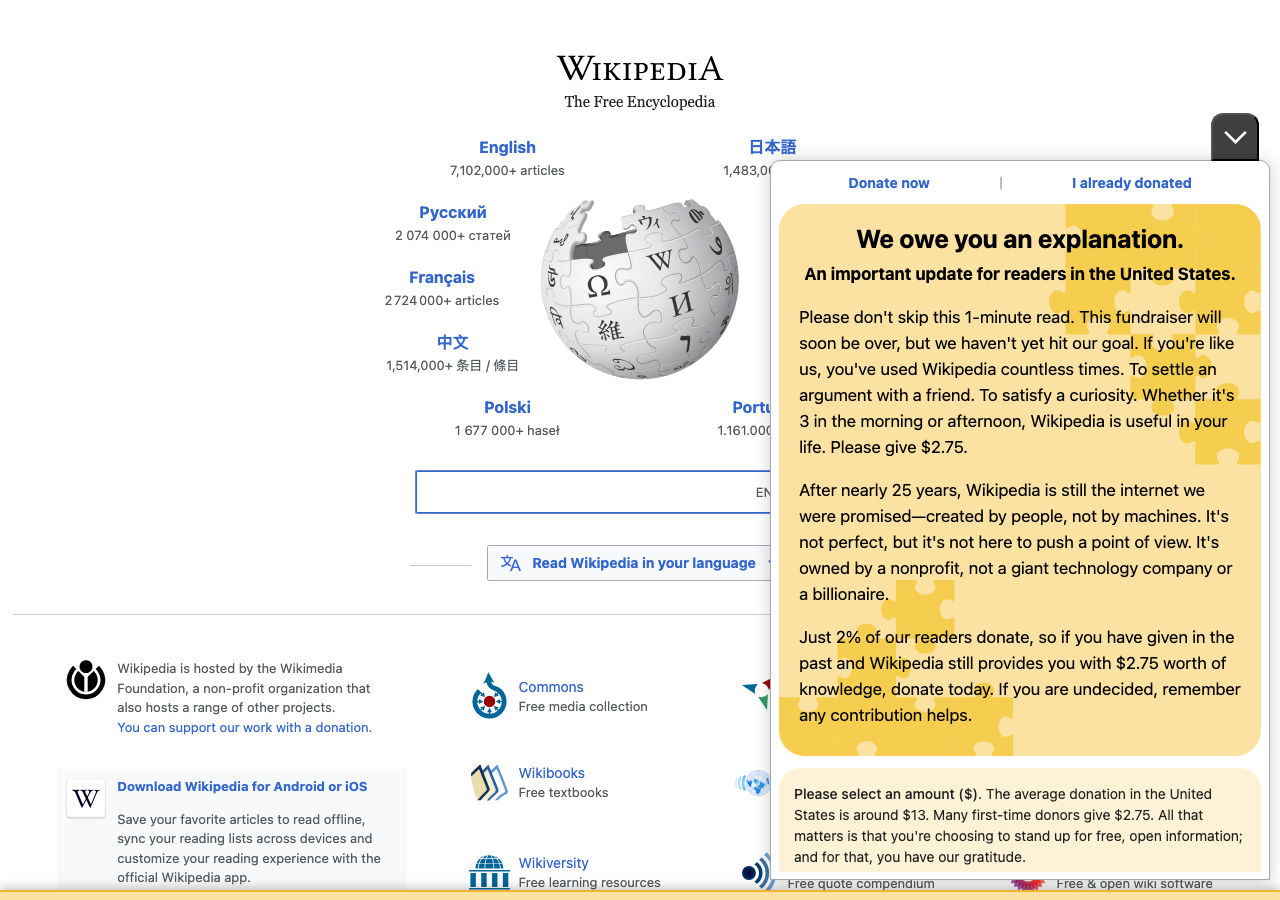


Current URL: https://www.wikipedia.org/

Clickable Elements:


Index,Text,Href
0,"English 7,102,000+ articles",//en.wikipedia.org/
1,"日本語 1,483,000+ 記事",//ja.wikipedia.org/
2,Русский 2 074 000+ статей,//ru.wikipedia.org/
3,Deutsch 3.075.000+ Artikel,//de.wikipedia.org/
4,Français 2 724 000+ articles,//fr.wikipedia.org/
5,Español 2.078.000+ artículos,//es.wikipedia.org/
6,"中文 1,514,000+ 条目 / 條目",//zh.wikipedia.org/
7,Italiano 1.947.000+ voci,//it.wikipedia.org/
8,Polski 1 677 000+ haseł,//pl.wikipedia.org/
9,Português 1.161.000+ artigos,//pt.wikipedia.org/



Asking LLM for decision...

Proposed Action:
   Action: click_by_index
   Reason: To search for 'Model Context Protocol' on Wikipedia, I need to click the search option.
   Full: {"action": "click_by_index", "index": 10, "reason": "To search for 'Model Context Protocol' on Wikipedia, I need to click the search option."}

*** HUMAN-IN-THE-LOOP ***
Action rejected. Stopping.

Final State:


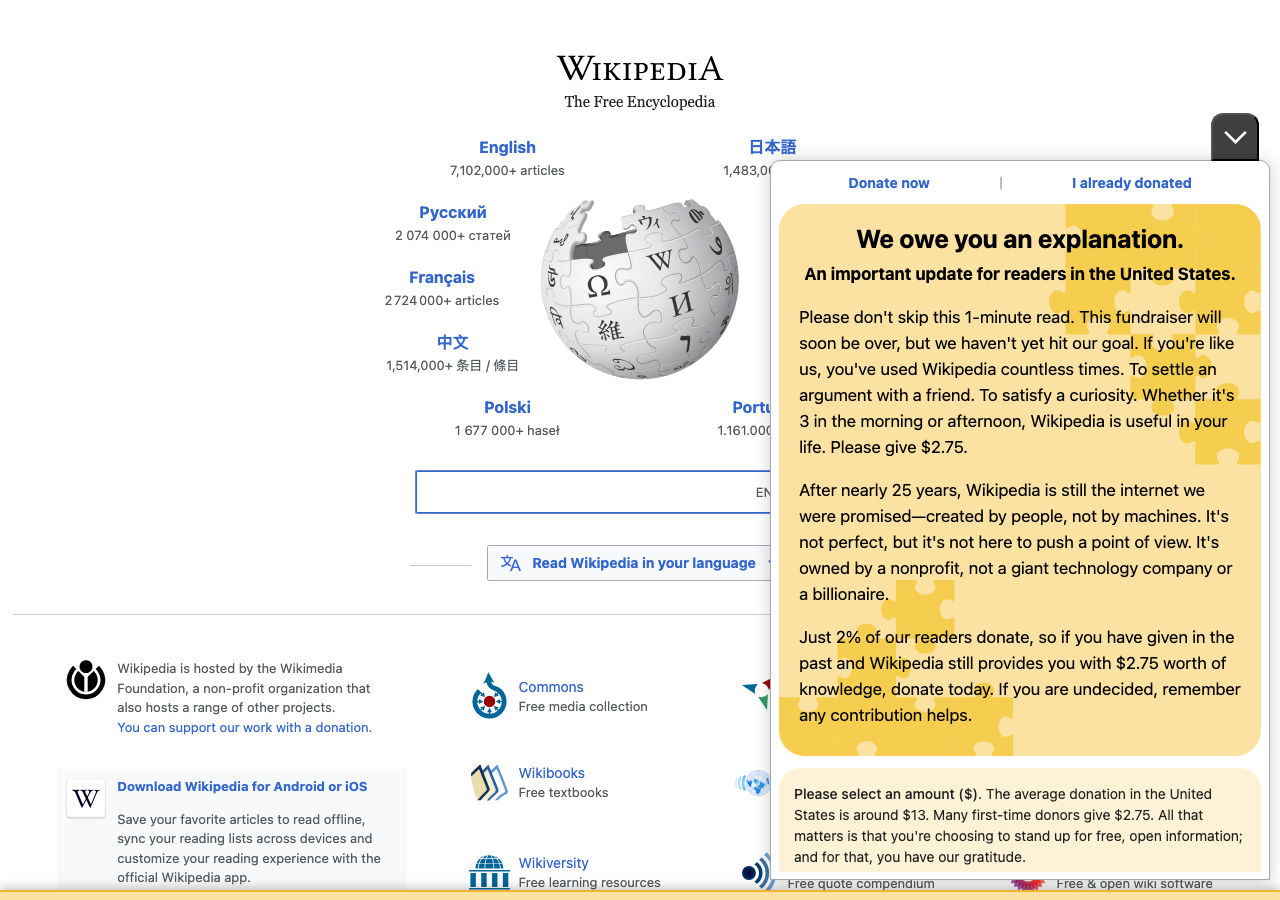

In [1]:
%run 4_OpenAI_CUA.py

[OK] API Key set
[OK] Configuration complete!
[OK] Helper functions defined!
[OK] LLM Decision Maker defined!
[OK] Action Executor defined!
[OK] Agent ready to run!

Starting agent... (type 'y' to approve each action)

Goal: Search Wikipedia for "Model Context Protocol" and extract the first paragraph.

Navigating to https://www.wikipedia.org/...

STEP 1


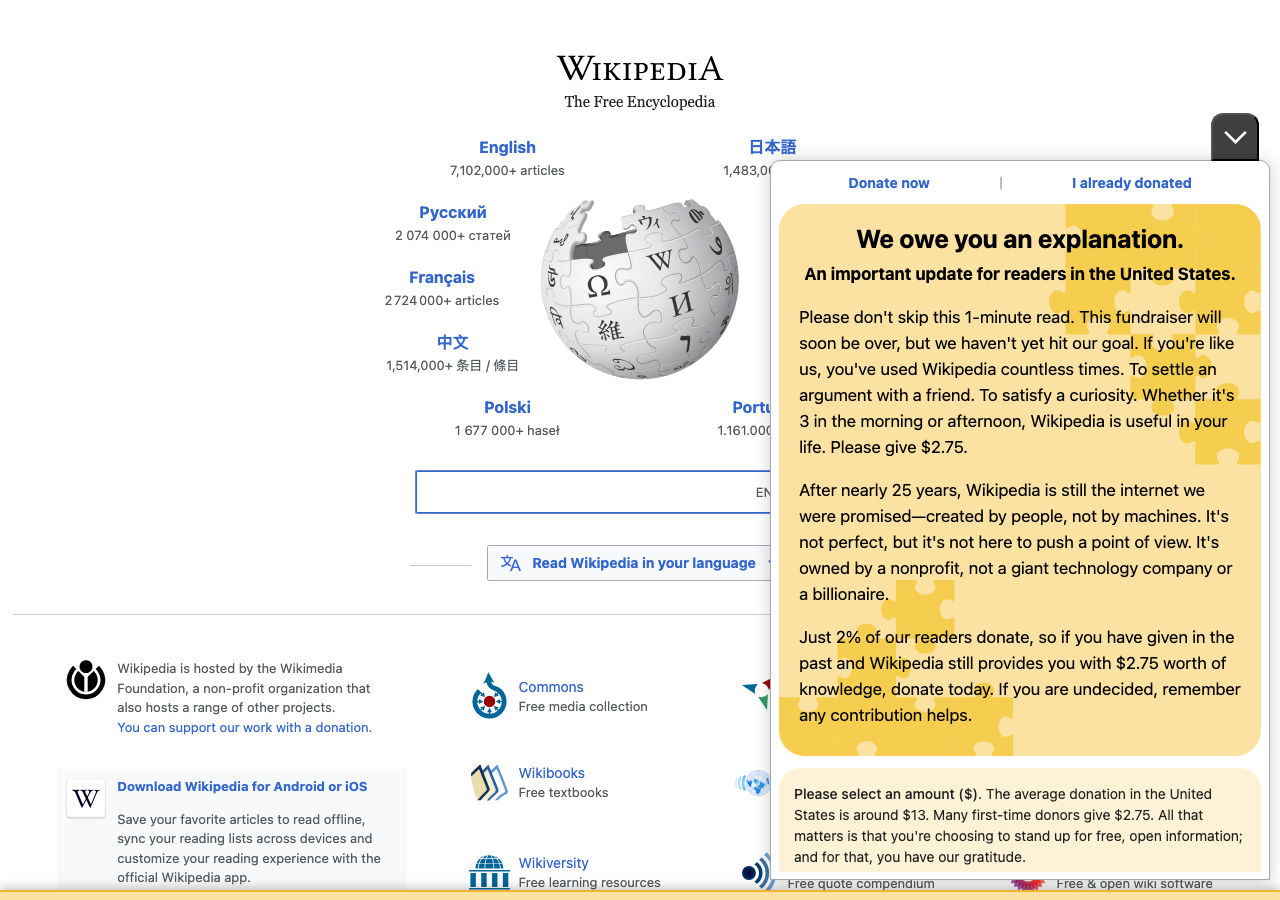


Current URL: https://www.wikipedia.org/


Index,Text,Href
0,"English 7,102,000+ articles",//en.wikipedia.org/
1,"日本語 1,483,000+ 記事",//ja.wikipedia.org/
2,Русский 2 074 000+ статей,//ru.wikipedia.org/
3,Deutsch 3.075.000+ Artikel,//de.wikipedia.org/
4,Français 2 724 000+ articles,//fr.wikipedia.org/
5,Español 2.078.000+ artículos,//es.wikipedia.org/
6,"中文 1,514,000+ 条目 / 條目",//zh.wikipedia.org/
7,Italiano 1.947.000+ voci,//it.wikipedia.org/
8,Polski 1 677 000+ haseł,//pl.wikipedia.org/
9,Português 1.161.000+ artigos,//pt.wikipedia.org/



Asking Claude for decision...

Proposed Action:
   Action: click_by_index
   Reason: I'm on the Wikipedia main page and need to access the English version to search for 'Model Context Protocol'. Clicking on the English link will take me to the English Wikipedia homepage where I can use the search functionality.
   Full: {"action": "click_by_index", "index": 0, "reason": "I'm on the Wikipedia main page and need to access the English version to search for 'Model Context Protocol'. Clicking on the English link will take me to the English Wikipedia homepage where I can use the search functionality."}

*** HUMAN-IN-THE-LOOP ***

Executing...
[OK] Clicked element at index 0

STEP 2


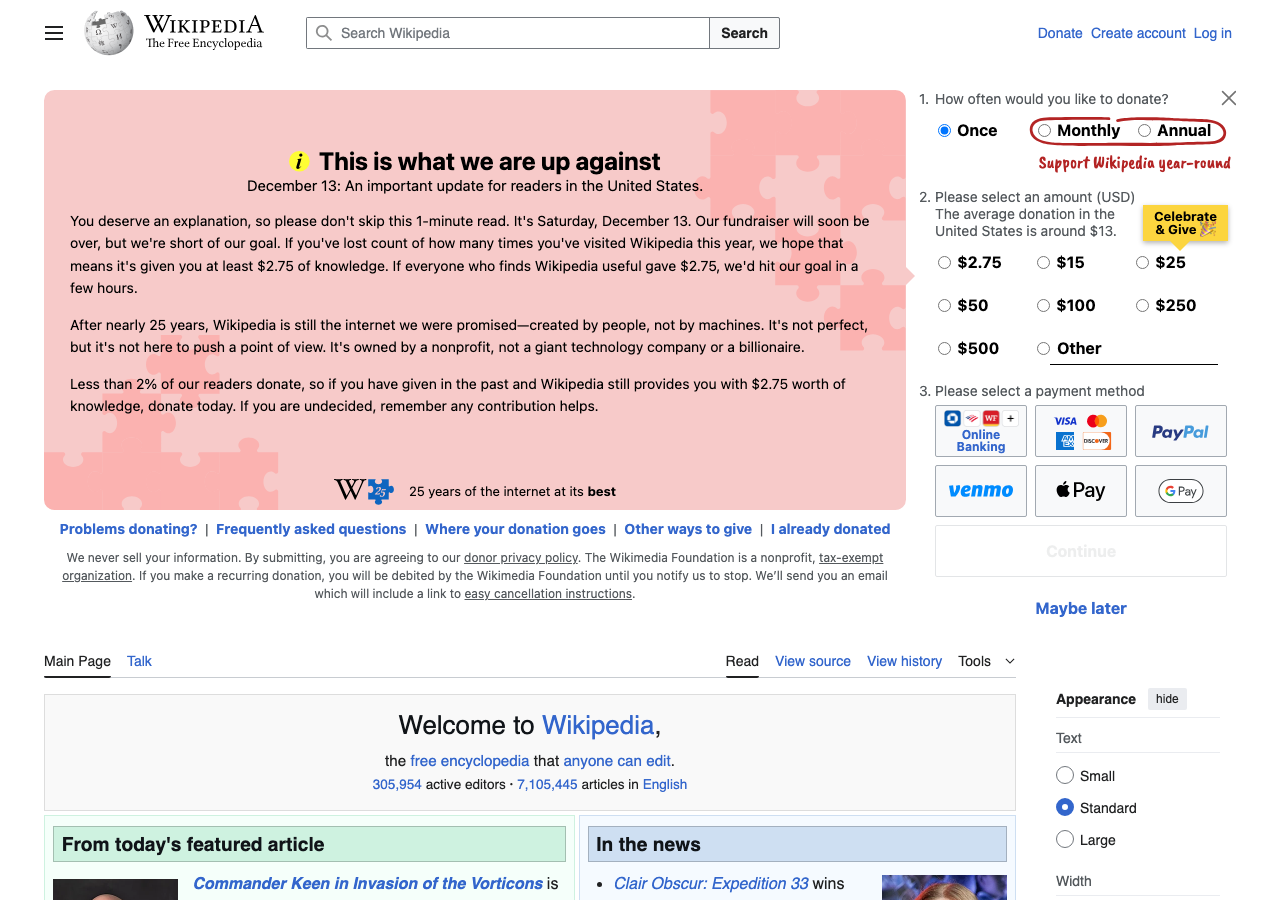


Current URL: https://en.wikipedia.org/wiki/Main_Page


Index,Text,Href
0,Jump to content,#bodyContent
1,(no text),(no href)
2,hide,(no href)
3,(no text),/wiki/Main_Page
4,(no text),/wiki/Wikipedia:Contents
5,(no text),/wiki/Portal:Current_events
6,(no text),/wiki/Special:Random
7,(no text),/wiki/Wikipedia:About
8,(no text),//en.wikipedia.org/wiki/Wikipedia:Contact_us
9,(no text),/wiki/Help:Contents



Asking Claude for decision...

Proposed Action:
   Action: type_and_enter
   Reason: I need to search for 'Model Context Protocol' on Wikipedia. I can see this is the Wikipedia main page, so I need to use the search functionality to find the article.
   Full: {"action": "type_and_enter", "selector": "input[name='search']", "text": "Model Context Protocol", "reason": "I need to search for 'Model Context Protocol' on Wikipedia. I can see this is the Wikipedia main page, so I need to use the search functionality to find the article."}

*** HUMAN-IN-THE-LOOP ***
Action rejected. Stopping.

Final State:


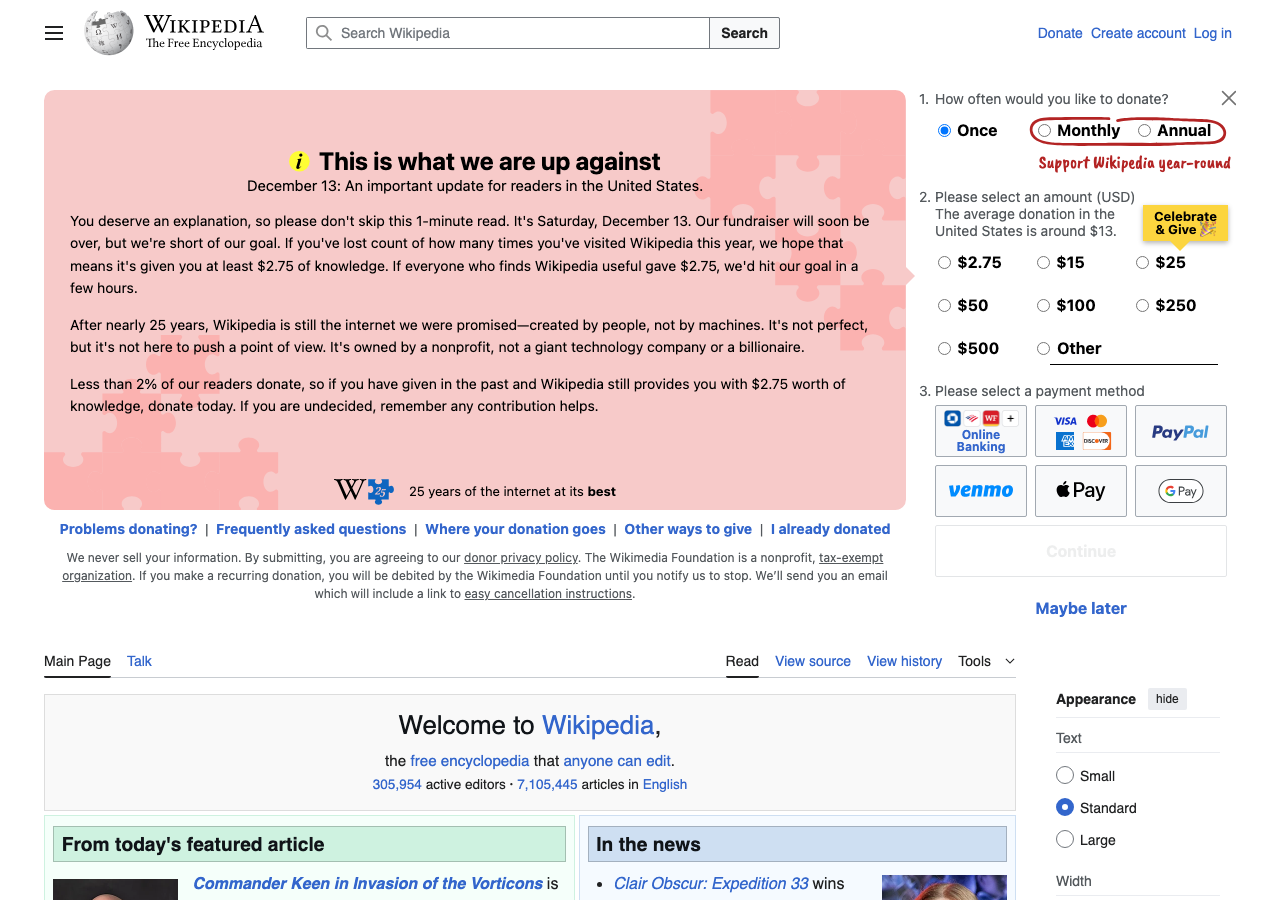

In [2]:
%run 4_Anthropic_CUA.py

Key Changes from OpenAI to Anthropic   

 | Aspect | OpenAI | Anthropic | 
  | --- | ---- | ----- | 
 | Import | from openai import OpenAI | import anthropic | 
 | Client | client = OpenAI() | client = anthropic.Anthropic() | 
| API Key env var | OPENAI_API_KEY | ANTHROPIC_API_KEY |
 | API Call | client.chat.completions.create() | client.messages.create() | 
  | Model | gpt-4o-mini | claude-sonnet-4-20250514 | 
   | Response |  accessresp.choices[0].message.content | response.content[0].text | 

Want to modify the demo? Try these:  

1. **Change the search term**: Modify `SEARCH_TERM` to search for something else
2. **Add new actions**: Extend the action types (scroll, hover, etc.)
3. **Remove HITL**: Comment out the approval step for fully autonomous operation
4. **Use a different model**: Try `gpt-4o` for better reasoning

---

# 4. Model Context Protocol (MCP)

Every LLM provider has a different tool use implementation. MCP creates a **universal standard** for tool communication.

The core idea of MCP is to create a **universal, standardized protocol** for how a client (like an IDE or an LLM host) communicates with a server that provides tools and data.
- It's conceptually similar to tool use but aims to be universally compatible.
- It abstracts away server details, which enhances privacy and security.
- If universally adopted, it would make it trivial to swap LLMs and tools from different providers.

<img src="./pic/4_mcp.png" width=400>

## MCP Server Components

An MCP server exposes three main types of capabilities:   

| Component | Analogy | Purpose |
|-----------|---------|---------|
| **Resources** | like `GET` endpoints in a REST AP| Fetch data without side effects or performing significant computation|
| **Tools** | `POST` endpoints | Perform actions with side effects and may require significant computation|
| **Prompts** | Templates | Reusable prompt patterns that can be hosted on the server.|

<img src="./pic/4_mcp.gif" width=400>

## MCP Code Example

```python
from mcp.server.fastmcp import FastMCP

mcp = FastMCP("My RAG App")

@mcp.resource("config://app")
def get_config() -> str:
    """Static configuration data"""
    return "App configuration here"

@mcp.resource("users://{user_id}/profile")
def get_user_profile(user_id: str) -> str:
    """Dynamic user data"""
    return f"Profile data for user {user_id}"

@mcp.tool()
def search_documents(query: str) -> str:
    """Search RAG pipeline for relevant documents"""
    # Your RAG search logic here
    return results
```

## Where RAG Fits in MCP

Your RAG system could be exposed as an MCP server:
- **Resource**: Document metadata, chunk counts
- **Tool**: `search_documents`, `get_context`
- **Prompt**: Standard RAG prompt templates

---



# 5. Fine-Tuning
So far, we have primarily improved model performance by optimizing prompts and building RAG workflows. However, when these methods reach their limits, we need to consider directly modifying the model itself to turn it into a **domain-specific expert**, which is fine-tuning.  

Fine-tuning is already a **very mature commercial service**. Leading cloud and AI companies offer fine-tuning platforms that greatly simplify the process. **Major service providers** include:
- [OpenAI](https://platform.openai.com/docs/guides/model-optimization)
- AWS Bedrock: 
  - [Customize models with own data using fine-tuning and continued pre-training](https://aws.amazon.com/blogs/aws/customize-models-in-amazon-bedrock-with-your-own-data-using-fine-tuning-and-continued-pre-training/)
  - [Fine-tune Anthropic’s Claude 3 Haiku](https://aws.amazon.com/blogs/machine-learning/fine-tune-anthropics-claude-3-haiku-in-amazon-bedrock-to-boost-model-accuracy-and-quality/)
- [Together.ai](https://docs.together.ai/docs/fine-tuning-quickstart)
- [Predibase](https://docs.predibase.com/fine-tuning/overview)
- [Fireworks.ai](https://docs.fireworks.ai/fine-tuning/fine-tuning-models)
- [Vertex AI (Google Cloud)](https://docs.cloud.google.com/vertex-ai/generative-ai/docs/models/tune-models)
- [Azure AI Foundry](https://learn.microsoft.com/en-us/azure/ai-foundry/concepts/fine-tuning-overview?view=foundry-classic)

<img src="./pic/4_Fine-tuning process.jpg" width=500>


## When to Fine-Tune (vs RAG vs Prompt Engineering)

Fine-tune when RAG + prompts + agents are **not enough**:

| Scenario | Solution |
|----------|----------|
| Need current information | RAG ✓ |
| Need specific behavior | Prompt Engineering ✓ |
| Need domain style/tone | **Fine-tuning** |
| Need specialized reasoning | **Fine-tuning** |
| Need consistent format | **Fine-tuning** |


So an excellent, practical workflow for **developing a real-world LLM application**:  
- Step 1: Start with an Existing Model (**Pre-trained**)   
  - You begin by leveraging a publicly available, powerful pre-trained base model (e.g., Llama 3, Mistral, GPT-3.5). 
  - This saves the immense cost and time of training from scratch.
- Step 2: Try Zero-Code Solutions First (**RAG / Prompt Engineering**)     
  - Before committing to the complexity and cost of training your own model, you attempt to solve your problem using inference-time techniques.    
  - Why do this first? Because these methods are generally cheaper, faster to implement, and easier to update than fine-tuning.
- Step 3: Evaluate and Iterate (If Not Good Enough)    
  - If the prompt-engineered or RAG-powered application still doesn't meet your desired performance, accuracy, style, or reliability requirements, you move to the more resource-intensive step:
  - **Fine-tuning (Post-training)**
  - This adjusts the model's weights to hard-code the exact behavior, style, or specific knowledge you need, which the lighter methods couldn't achieve.

core concepts and the typical implementation strategy:   
- **Offline Training Phases** (Building the Model's "Brain"):
  - **Pre-training**: The massive initial step to create the foundational language model.
  - **Fine-tuning (Post-training)**: Additional training to specialize the model's behavior and style using targeted data.
- **Online/Inference Phases** (Using the Deployed Model):
  - **RAG**: An architectural pattern implemented to fetch external, up-to-date knowledge at the moment a user asks a question, augmenting the prompt dynamically.
  - **Prompt Engineering**: The method of crafting precise instructions for the model's input to guide its response effectively, whether used alone or in combination with RAG.



## Fine-Tuning Methods
a highly intuitive and useful way to categorize fine-tuning methods:   
- Step 1: What to Learn (The Objective/Loss Function)
- Step 2: How to Train (The Mechanism/Implementation)

<img src='./pic/4_fine-tuning-methods.png' width=400>

combining **SFT with PEFT** is currently considered the mainstream and most practical approach for fine-tuning Large Language Models (LLMs) in both industry and the open-source community. 

This combination has become the de facto standard due to a powerful balance of performance and efficiency:



### Training Methods - WHAT to optimize

| Method 	| Objective	| Data Type| 
| --| ---| ---| 
| SFT (Supervised Fine-Tuning)| 	Teach the model a specific style, format, or instruction-following ability.	| Prompt/Response pairs (high-quality examples).| 
| DPO (Direct Preference Optimization)| 	Teach the model to prefer certain responses over others (alignment with human preferences).| 	Paired examples (preferred/rejected responses).| 
| RFT (Reinforcement Fine-Tuning)| 	(Often used interchangeably or as a broader term for DPO/RLHF) Involves learning from a reward signal, typically through methods like RLHF (Reinforcement Learning from Human Feedback).	| Preference data used to train a reward model, which then guides RL.| 



#### 1. Supervised Fine-Tuning (SFT)

**Use case**: Teach model new skills or output formats    
- Classification / Translation
- Formatting 
- Handle complex prompt following

This is the **most common** type of fine-tuning, used to teach a model **how to perform a specific task or follow a particular output format**. For example, performing text classification, translation, or ensuring the model strictly adheres to a desired JSON format. When you need the model to learn a new "skill," SFT is the preferred choice.




#### 2. Direct Preference Optimization (DPO)

**Use case**: Align model's tone, style, and values

DPO does not teach the model new skills but rather aligns the model's "values" to make its output better conform to human preferences. This is typically used to optimize the model's **tone and style**, or to help it **grasp key points** and **sound more like a domain expert** when answering open-ended questions.

#### 3. Reinforcement Fine-tuning (RFT)
**Use case**: Domain specific reasoning tasks    
 
This is a more advanced method suitable for tasks that require the model to perform **multi-step, complex, domain-specific reasoning**.



### Parameter Strategy - How to train
| Method | Mechanism | Focus |
|--------|-----------|-------|
| **Full Fine-Tuning** | Updates all parameters of the base model. | Highest potential performance/customization, but resource-intensive and prone to forgetting. |
| **LoRA** (Low-Rank Adaptation) | Freezes the original model weights and injects small, trainable "adapter" matrices (A and B). | Parameter efficiency, speed, reduced memory usage. |
| **LoRA-FA** (Frozen-A LoRA) | Freezes matrix A, only trains matrix B. | Even more efficient than LoRA, ~50% fewer trainable parameters. |
| **VeRA** (Vector-based Random Matrix Adaptation) | Uses shared random frozen matrices across layers, only trains small scaling vectors. | Extreme parameter efficiency (~0.01%), minimal storage per task. |
| **LoRA+** | Same as LoRA but uses different learning rates for matrix A and B (higher LR for B). | Better convergence, improved performance over standard LoRA. |
| **Delta-LoRA** | Updates pretrained weights with the delta (difference) between consecutive LoRA updates. | Combines benefits of LoRA with gradual base model updates. |
| **QLoRA** (Quantized LoRA) | LoRA applied to a quantized (4-bit compressed) model. | Further memory reduction, allowing fine-tuning of very large models on consumer hardware. |
| **DoRA** (Weight-Decomposed LoRA) | Decomposes weights into magnitude and direction, applies LoRA to direction only. | Closer to full fine-tuning performance while maintaining efficiency. |
| **AdaLoRA** (Adaptive LoRA) | Dynamically allocates parameter budget across layers based on importance scores. | Optimal parameter distribution, better performance with same budget. |

<img src='./pic/4_Five_FineTuning_Tech.gif' width=500>

#### LoRA 

**The problem**: Full fine-tuning requires updating billions of parameters

**The solution**: Freeze base model, train small adapter matrices

```text
┌───────────────────────────────────────────────────┐
│  Base Model (Frozen)     LoRA Adapters (Trainable)│
│  ┌─────────────────┐     ┌─────────────────┐      │
│  │ 125,000,000     │  +  │    462,850      │      │
│  │   parameters    │     │   parameters    │      │
│  │    (frozen)     │     │  (0.37% of base)│      │
│  └─────────────────┘     └─────────────────┘      │
└───────────────────────────────────────────────────┘
```

**LoRA Configuration**:
```python
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,                           # Rank of LoRA matrices (most important)
    lora_alpha=32,                  # Scaling factor (usually 2 * r)
    lora_dropout=0.1,               # Dropout for regularization
    target_modules=["query", "value"]  # Which layers to adapt
)
```



## Implementation

### Preparing Fine-tuning Datasets
The effectiveness of fine-tuning largely depends on the quality of the dataset you provide.

#### SFT Dataset Format
An SFT dataset is typically a JSONL file, where each line is a JSON object 
containing a  messages list that simulates a complete conversation.
- **Single-turn Dialogue**     
  ```json
  {"messages": [
    {"role": "system", "content": "You are a helpful medical assistant."},
    {"role": "user", "content": "What are symptoms of flu?"},
    {"role": "assistant", "content": "Common flu symptoms include..."}
  ]}
  ```
- **Multi-turn with weights** (control what model learns)
  ```json
  {"messages": [
    {"role": "system", "content": "Marv is a sarcastic chatbot."},
    {"role": "user", "content": "What's the capital of France?"},
    {"role": "assistant", "content": "Paris", "weight": 0},
    {"role": "user", "content": "Can you be more sarcastic?"},
    {"role": "assistant", "content": "Paris, as if everyone doesn't know that already.", "weight": 1}
  ]}
  ```
  > `weight: 0` = don't learn from this | `weight: 1` = learn from this
- **Vision Model**   
  - Fine-tuning is also applicable to **multimodal models**. 
  - In this example, the user's input includes an image URL, and the  assistant's output is the image recognition result, "Danbo."
  ```json
  {"messages": [
      {"role": "system", "content": "You are an assistant that identifies uncommon cheeses."},
      {"role": "user", "content": "What is this cheese?"},
      {
        "role": "user",
        "content": [{
            "type": "image_url",
            "image_url": {
              "url": "https://upload.wikimedia.org/wikipedia/commons/3/36/Danbo_..."
            }
          }]
      },
      {"role": "assistant","content": "Danbo"}
  ]}
  ```

#### DPO Dataset Format

The DPO dataset format is different. It does not provide a single "correct" answer 
but instead provides **both a "preferred" and a "non_preferred" answer**.
- In this example, the model is shown two different responses to the same question. 
- Through training, it learns that the style of the preferred_output is better than that of the non_preferred_output
```json
{
  "input": {
    "messages": [{"role": "user", "content": "How cold is San Francisco today?"}],
    "tool": [],
    "parallel_tool_calls": true
  },
  "preferred_output": [
    {"role": "assistant", "content": "Today in San Francisco, it is not quite cold as expected..."}
  ],
  "non_preferred_output": [
    {"role": "assistant", "content": "It is not particularly cold in San Francisco today."}
  ]
}
```

### Training Core Hyperparameters
When launching a fine-tuning job, you need to configure several key hyperparameters  

| Parameter | Description | Typical Values |
|-----------|-------------|----------------|
| **Epochs** | The number of times the model will see the entire dataset | 1-5 |
| **Learning Rate** | Controls the magnitude of the weight updates inside the model at each step. It is typically set to a small value to avoid "over-learning" (overfitting) | 1e-5 to 5e-5 |
| **Batch Size** | The number of examples processed in each iteration. A larger batch size means the model's weights are updated less frequently| 4-32 |   


> Note: Service providers like OpenAI simplify these parameters, while platforms like Together.ai offer more extensive tuning options.



### Training Metrics to Monitor
During training, the system will output a series of metrics, which could be used to judging whether the fine-tuning is successful.

| Metric | What it means | Good sign |
|--------|---------------|-----------|
| `train_loss` | Error on training data | Decreasing |
| `valid_loss` | Error on validation data | Decreasing (not increasing!) |
| `train_accuracy` | Correctness on training | Increasing |
| `valid_accuracy` | Correctness on validation | Increasing |

- `train_loss`: 
  - Cross-entropy loss on the training set at that step.
  - **Lower is better**. 
  - It reflects <u>how well the model fits the training data</u>.
  - A **sharp drop early is expected**; 
  - flattening out over time means the model is converging.
- `train_mean_token_accuracy`
  - The <u>percentage of tokens predicted correctly on the training set</u>.
  - **Should increase** over time as the model learns.
  - If too high (near 1.0) with poor validation accuracy, it might suggest **overfitting**.
- `valid_loss`
  - Cross-entropy loss on the validation set at that step.
  - **Ideally decreases** during training.
  - If it starts increasing while `train_loss` decreases, **overfitting** is occurring.
- `valid_mean_token_accuracy`
  - Accuracy of token predictions on the validation set at that step.
  - Should **generally rise** with training.
  - Provides a generalization estimate on **how well the model will perform on unseen data**.
- `full_valid_loss`
  - Final evaluation loss on the entire validation set (not just a sample).
  - Used for **selecting the best checkpoint**.
- `full_valid_mean_token_accuracy`
  - <u>Final token accuracy on the complete validation set.</u>
  - Best metric to gauge the final model performance on validation data.
  - **Should align with what you observe in `valid_mean_token_accuracy`** if the validation sample was representative.


**Overfitting alert**: 
- If `train_loss` ↓ but `valid_loss` ↑ = overfitting!
- If `train_mean_token_accuracy` is too high (near 1.0) with poor validation accuracy



### Checkpoint Models & Composability

During the fine-tuning process, especially in multi-epoch training, the system creates a **checkpoint** for the [*model's state at the end of each epoch*](https://www.seagate.com/blog/checkpointing-in-ai-workload-a-primer-for-trustworthy-ai/).
- Each intermediate training can result in a checkpoint model
  - Openai create a full model checkpoint for you at the end of each training epoch.
- They are just like any fully trained model.
- Allows for composability of multiple methods

<img src="https://www.seagate.com/content/dam/seagate/assets/blog/images/checkpointing-in-ai-workload-a-primer-for-trustworthy-ai/Blog-Article_Checkpointing-in-AI-Workloads-A-Primer-for-Trustworthy-AI_image-1.jpg">

**What is a Checkpoint**: It is, in itself, **a fully functional, trained model**.  

**Combined Use (Composability)**: The checkpoint mechanism allows us to 
combine different fine-tuning methods. This is a very powerful and common 
industry practice:
1. First perform supervised fine-tuning (SFT) on your data.
2. Then refine with preference fine-tuning using continued fine-tuning on your SFT checkpoint.
3. Performing SFT on your dataset prior to DPO can significantly increase the resulting model quality, especially if your training data differs significantly from the data the base model observed during pretraining.

```text
┌────────────────────────────────────────────────────────────────┐
│                  COMPOSABLE FINE-TUNING                        │
│                                                                │
│  Base Model ──▶ SFT Checkpoint ──▶ DPO Checkpoint ──▶ Final    │
└────────────────────────────────────────────────────────────────┘
```



### SFT + LoRA

In [2]:
%run 4_sft_lora.py

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 25000/25000 [00:04<00:00, 5252.70 examples/s]


trainable params: 1,181,954 || all params: 125,829,124 || trainable%: 0.9393


/Users/yannisshen/anaconda3/envs/genai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.687858
2,No log,0.681007
3,No log,0.675837


/Users/yannisshen/anaconda3/envs/genai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/yannisshen/anaconda3/envs/genai/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted class ID: 0
Prediction: Negative


## Distillation
Data generation strategy, not a training method itself.  

**Use case**: Transfer knowledge from large expensive model to small cheap model.

```
Teacher Model (GPT-4)  ──generates──▶  Training Data  ──trains──▶  Student Model (Small)
```
Distillation is Usually Combined with SFT.

---

# 6. Evaluation & Benchmarking
After fine-tuning a model, we need a systematic way to evaluate the new model's performance.     
Evaluation: Measuring model performance, "Is my model good enough?"   
Benchmarking: Comparing against a standard, "How does my model rank vs others?"  

There are **two major categories** of tasks and, consequently,two major approaches to evaluation.   

| Close-ended | Open-ended |
|-------------|------------|
| Limited correct answers | The answer is generative and 
subjective, with many possible good answers |
| Like multiple choice | Like essay questions |
| Easy to evaluate | Hard to evaluate |
| Examples: standard ML (classification), "Do you like this prdouct" | Examples: summarization, creative writing, "What do you think of this product" |

**Examples of Close-ended Tasks**    
- **Sentiment Classification**: Is this review positive or negative?
- **Extractive QA**: Find the exact phrase in a document that answers a question.
- **Entailment**: Does sentence A logically imply sentence B
- **Coreference Resolution**: Pronoun matching


## Evaluating Close-ended Tasks

These tasks are the most straightforward to evaluate, as they align with traditional machine learning classification problems. We can use standard metrics like accuracy,precision, recall, and F1 score.

### Standard ML Metrics   
- **Accuracy**: % of correct predictions
- **Precision**: TP / (TP + FP) — of predicted positives, how many were right?
- **Recall**: TP / (TP + FN) — of actual positives, how many did we find?
- **F1 Score**: Harmonic mean of precision and recall

### Benchmarks for Close-ended Tasks
#### Single-task Benchmarks
These are datasets focused on **one specific task**   

| Benchmark | Task Type | Description |
|-----------|-----------|-------------|
| SST | Sentiment Analysis | Stanford Sentiment Treebank - sentiment classification |
| IMDB | Sentiment Analysis | Movie review sentiment classification |
| SNLI | Natural Language Inference | Stanford Natural Language Inference - entailment task |
| MultiNLI | Natural Language Inference | Multi-Genre Natural Language Inference - entailment across genres |
| SQUaD | Question Answering | Stanford Question Answering Dataset - extractive QA |
| NaturalQuestions | Question Answering | Google's dataset of real user questions and answers |

#### Multi-task Benchmarks
These are more comprehensive and designed to test a model's **general language understanding** across a variety of  challenges.  

- [SuperGLUE](https://super.gluebenchmark.com/leaderboard) is a well-known and challenging **set of natural language understanding (NLU) tasks**. 
  - It test the “general language capabilitiesˮ. 
  - A widely recognized benchmark that combines multiple tasks like reading comprehension, causal reasoning, and coreference resolution to produce a single score reflecting a model's overall language capability. 
  - Core Components includes: BoolQ, CB, COPA, MultiRC, ReCoRD, RTE, WSC, WiC.

    <img src="./pic/4_superglue.png" width=700>

    《[SuperGLUE: A Stickier Benchmark for General-Purpose Language Understanding Systems](https://w4ngatang.github.io/static/papers/superglue.pdf)》:   

    <img src="./pic/4_superglue_sub_eg.png" width=500>  

- [MMLU (Massive Multitask Language Understanding)](https://huggingface.co/spaces/TIGER-Lab/MMLU-Pro)
  - A challenging benchmark that tests a model's knowledge across 57 academic and professional subjects, from astronomy to law.
    <img src="./pic/4_mmlu_leaderboard.png" width=700>  
    
    <img src="./pic/4_top-mmlu-open-closed.png" width=500>

**Summary:**   

| Benchmark | Task Type | Description |
|-----------|-----------|-------------|
| **SuperGLUE** | General Language Capabilities | set of following 8 tasks |
| BoolQ | Reading Comprehension | Yes/no questions based on reading texts |
| MultiRC | Reading Comprehension | Multiple-choice questions requiring reading texts |
| CB | Natural Language Inference | Commitment Bank - textual entailment task |
| RTE | Natural Language Inference | Recognizing Textual Entailment |
| COPA | Causal Reasoning | Choice of Plausible Alternatives - cause and effect relationships |
| ReCoRD | Question Answering | Reading Comprehension with Commonsense Reasoning Dataset - QA with reasoning |
| WiC | Word Sense Disambiguation | Words in Context - determining meaning of words |
| WSC | Coreference Resolution | Winograd Schema Challenge - resolving pronoun references |
| **MMLU** | Knowledge & Reasoning | Massive Multitask Language Understanding - testing knowledge across 57 subjects |

## Evaluating Open-ended Tasks
This is where evaluation becomes much more difficult and nuanced, because there is no single "correct" answer. How do you grade a summary or a poem? There are three primary methods.

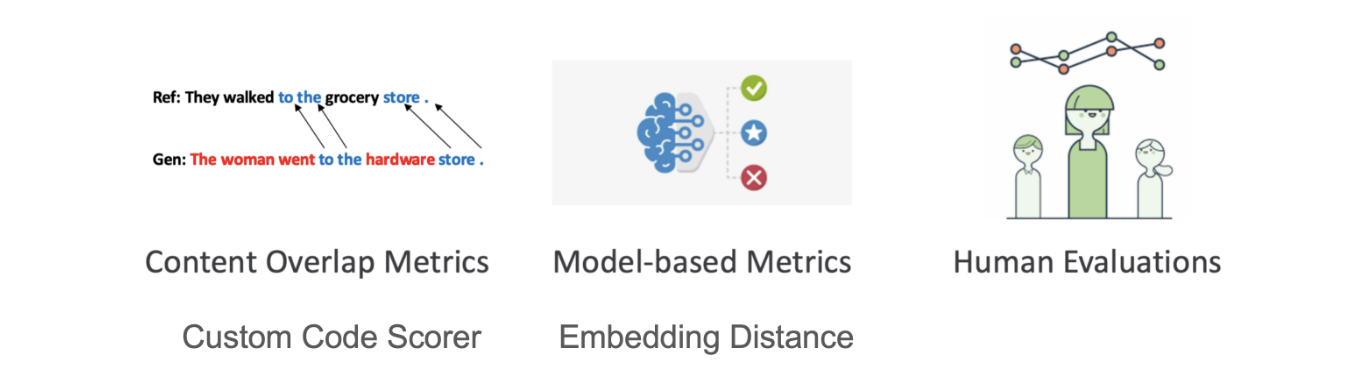

### Method 1: Content Overlap Metrics

These are automatic metrics that work by comparing the **n-grams (sequences of words)** in the <u>model-generated text</u> to a <u>"golden" reference text</u>.

| Metric | Type | Best for |
|--------|------|----------|
| **BLEU** | Precision-oriented | Translation - measures n-gram overlap with reference translations |
| **ROUGE** | Recall-oriented | Summarization - measures recall of n-grams and longest common subsequences |
| **METEOR** | Precision & Recall balanced | Translation - incorporates synonyms, stemming, and handles paraphrasing better than BLEU |
| **CIDEr** | Consensus-based | Image Captioning - weights n-grams by TF-IDF to measure consensus with human descriptions |

- **Limitation**:  
  - Only measuere lexical (word-for-word) similarity, not semantic meaning.
  - They will heavily penalize a perfectly good answer that just uses different words than the reference text.
  - The more open-ended the answer, the worse the performance
- **Pros**: Fast & Efficient
```text
Reference: "They walked to the grocery store."
Generated: "The woman went to the hardware store."
                ↑           ↑              ↑
            Overlap:    "to the"        "store"

BLEU would score this highly despite being semantically different!
```

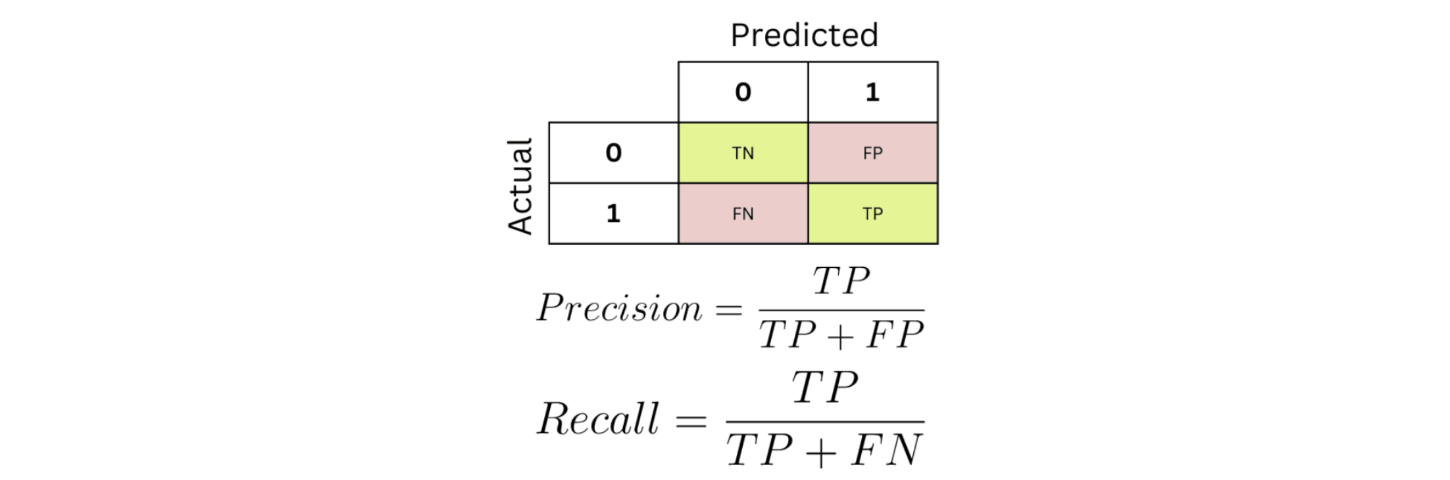


> [easy guide to rouge, blue, and metor](./cheatsheets/Easy%20Guide%20to%20ROUGE,%20BLEU,%20and%20METEOR_%20Metrics%20to%20Evaluate%20LLM%20Outputs%20_%20by%20Diwakar%20Kumar%20_%20Medium.html)



### Method 2: Model-based Metrics

Instead of just comparing words, we use **another AI model to "grade"** the output. This can be done in a few ways:

- **Embedding Distance**: 
  - Calculate the **cosine similarity** between the embedding of the generated text and the reference text. 
  - Better at capturing semantic meaning
  - Academia algorithms: Sentence Movers Similarity, BERTSCORE, BLEURT, MAUVE, ...
  - **Important Failure Case** (Comparison)
    - Source-of-truth (references) data
    - References are wrong
    - Reference-based evaluation methods are only as good as the references
      - Model to decide directly (without a “source-of-truthˮ/reference label)
      - E.g. Use LLMs directly

- **LLM-as-a-Judge (Reference-Free)**: 
  - Use a powerful LLM to grade outputs
  - This is the modern approach. 
  - We provide it with the original prompt, the model's output, and a detailed scoring rubric, and ask it to provide a grade. 
  - This is powerful because it can assess qualities like creativity or helpfulness without needing a reference text.
  - pros:
    - 100x Cheaper than human evaluation
    - 100x Faster
    - Often agrees with humans more than humans agree with each other
  - Issues: Model bias still exists (but lower than humans)

```python
# LLM-as-a-Judge prompt
"""
Score the following response on a scale of 1-5:
- Faithfulness: Is it grounded in the provided context?
- Relevance: Does it answer the question?
- Helpfulness: Is it useful to the user?

Context: {context}
Question: {question}
Response: {response}

Provide scores and reasoning.
"""
```




### Method 3: Human Evaluation

**Gold standard but problematic:**
- Slow and expensive
- Inter-annotator disagreement (subjectivity, across time)
- Not reproducible
- Correct incentives matter
- Precision not recall

Chatbot Evaluation - Side-by-side Human Eval
- Chatbot Arena: https://lmarena.ai/?leaderboard  
- People rate answers from models side-by-side
- Issues:
  - Cost
  - Human annotation takes large, community effort
  - New models take a long time to benchmark
  - Only notable models get benchmarked
  - Typing random questions into a head-to-head website may not be representative
  - Ratings by random users may represent some surface-level engagement


## Another Approach - look at everything
- [Holistic evaluation of language models (HELM)](https://crfm.stanford.edu/helm/)
- [Huggingface open llm leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/)

<img src='./pic/4_helm.png' width=600>  

<img src='./pic/4_huggingface_leaderboard.png' width=600>

## RAG-Specific Evaluation

**Evaluating Retrieval:**
| Metric | What it measures |
|--------|------------------|
| **Recall@k** | Of relevant docs, what % did we retrieve in top-k? |
| **Precision@k** | Of retrieved docs, what % are relevant? |
| **MRR** | Average reciprocal rank of first relevant result |

**Evaluating Generation:**
| Criterion | Question |
|-----------|----------|
| **Faithfulness** | Is answer grounded in retrieved context? |
| **Relevance** | Does answer address the question? |
| **Helpfulness** | Is answer useful to the user? |

Debugging Pattern  

```text
Bad Answer? 
    │
    ▼
Check Retrieval First
    │
    ├── Retrieved chunks relevant? ──NO──▶ Fix retrieval
    │         │                            (chunking, embeddings, search)
    │        YES
    │         │
    │         ▼
    └── Check Generation
              │
              └── Context good but answer bad? ──▶ Fix generation
                                                   (prompts, model)
```



## Evaluation Challenges

| Challenge | Description |
|-----------|-------------|
| **Agent/Workflow Evaluation** | Multi-step processes with intermediate steps |
| **Consistency** | Performance changes with prompt format changes |
| **Contamination** | Model may have been trained on test data |
| **Multi-language** | Different performance across languages |

**Agent / Workflow Evaluation**: 
- How do you evaluate a complex, multi-step agentic workflow where you can't easily judge the intermediate steps?
- Multiple steps involving multiple models
- Input/output of intermediate steps are not created/consumed by human
- Can still evaluate and improve each of them separately but not fully representative

**Consistency**: 
- The performance of a model can sometimes change just by slightly altering the format of the prompt.
- Changing format can cause performance changes

**Contamination**: 
- This is a huge problem. 
- It's the risk that the model was secretly trained on the evaluation dataset,making its score on that test completely invalid.
- Trained on the evaluation dataset
- Closed models you donʼt know what they have trained on (private test set, dynamic test set)
- Detection methods like looking at token probabilities (min-k-prob, exchangeability test, ...)

## Evaluation in Action: The OpenAI Evals Framework

This framework provides the flexibility to implement all the evaluation methods 
we've discussed, from simple string matching for close-ended tasks to 
sophisticated model-based grading for open-ended ones.  

To run an evaluation, you need three things:

1. **Test Dataset**: A list of test cases in JSONL format.[JSONL]
   a. Test data set
   ```json
   { "item": { "ticket_text": "My monitor won't turn on!", "correct_label": "Hardware" }}
   { "item": { "ticket_text": "I'm in vim and I can't quit!", "correct_label": "Software" }}
   { "item": { "ticket_text": "Best restaurants in Cleveland?", "correct_label": "Other" }}
   ```
   
2. **Test Data Schema**: A definition of the structure of your test data. (`data_source_config`)
   ```json
   {
    "type": "custom",
    "item_schema": {
        "type": "object",
        "properties": {
        "ticket": { "type": "string" },
        "category": { "type": "string" }
        },
        "required": ["ticket", "category"]
    },
    "include_sample_schema": true
    }
   ```
3. **Grader**: The logic that determines if a model's output passes or fails for a given test case.(`testing_criteria`). OpenAI provides several types of graders:  
   - **Model based**: Use an LLM (like o3-mini) with a custom prompt and rubric to act **as a scorer or labeler**.
   - **Code based**: Execute custom **Python** code to programmatically evaluate the output (e.g., using regular expressions).
   - **Built-in Checks**: Simple **string comparisons** ("equals", "contains") or fuzzy matching using content overlap metrics like **BLEU and ROUGE**

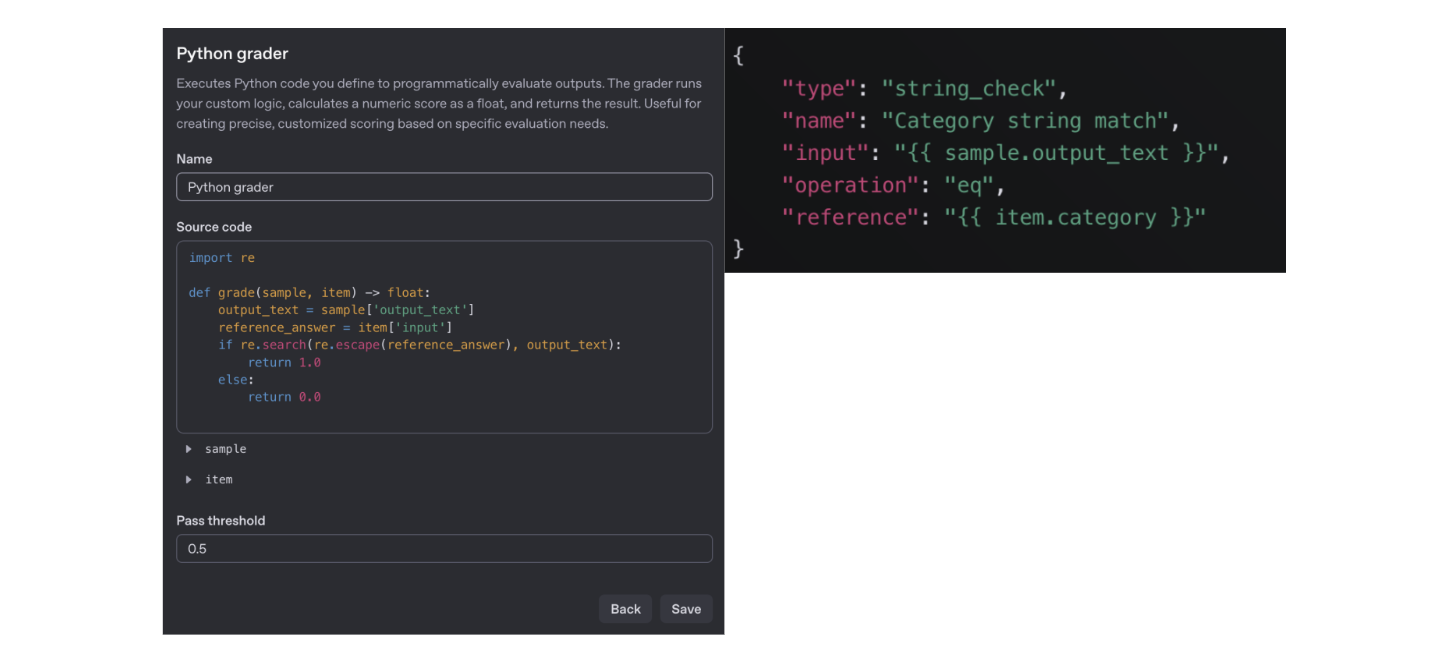